# Fitting occultation chord to 3D shape models

Usually, occultation chords are fitted to simples shapes like circles and ellipses. However, for small bodies this may not be good enough, since they are not expected to be rounded bodies. In some cases, we have a 3D shape model defined from rotational lightcurve inversion, and we want to compare numericaly the occultation chords with these models.

For this, since SORA v0.3.0, a method was implemented to include 3D shape models to be fitted to the occultations.

**Important note**: SORA does not derive a 3D shape model. It uses 3D shape models already derived from other sources to be fitted with occultation chords.

In this example, we will use the 3D shape model of Phoebe and fit the occultation chords observed on July 06th, 2017. The results here presented are based, although not equal to, the occultation published by Gomes-Júnior et al. (2020) and available on [A&A](https://academic.oup.com/mnras/article/492/1/770/5681400) and [Arxiv](https://arxiv.org/abs/1910.12188)

To replicate the process shown below, it is necessary to download the 3D shape model of Phoebe [here](https://3d-asteroids.space/moons/S9-Phoebe). The file must be the in "OBJ" format. Either the 50k or 200k versions will work, however the 200k one will demand more processing. The surface texture can also be downloaded and included in the process, but it is not relevant for the fitting process, only for plottings.

**Important note**: To see the details for all the methods available in the `Shape3D` class, please refer to the body guideline.

In [1]:
# The following commands download and save the 3D shape model from Gaskell.
import requests
response = requests.get("https://3d-asteroids.space/data/moons/models/S9_Phoebe.obj")
open("Phoebe_Gaskell_50k_poly.obj", "wb").write(response.content)
response = requests.get("https://3d-asteroids.space/data/moons/textures/S9_Phoebe/Phoebe.jpg?size=max")
open("Phoebe_Grayscale.jpg", "wb").write(response.content)

218918

First of all, let's define the occulting body, providing the 3D shape model.

In [2]:
from sora import Body
phoebe = Body(name="Phoebe", shape="Phoebe_Gaskell_50k_poly.obj", ephem="horizons")
# Now, we include the texture in the shape of Phoebe
phoebe.shape.texture = "Phoebe_Grayscale.jpg"

SORA version: 0.3


Now, let's define the occultation parameters using the Gaia-DR3 database

In [3]:
from sora import Occultation
occ = Occultation(body=phoebe, star="17 31 03.03926 -22 00 58.09752", time='2017-07-06 16:04:09.020')

1 GaiaDR3 star found band={'G': 10.334186}
star coordinate at J2016.0: RA=17h31m03.03930s +/- 0.1084 mas, DEC=-22d00m58.0798s +/- 0.0783 mas



Finally, let's include the observations. These values come directly from Gomes-Júnior et al. (2020).

In [4]:
from sora import Observer, LightCurve
# The observers
obs1 = Observer(name='Hamamatsu', lon='137 44 23', lat='34 43 07.0', height=17)
obs2 = Observer(name='Miharu', lon='140 26 04.2', lat='37 25 36.7', height=274)
# The "lightcurves"
lc1 = LightCurve(name='Hamamatsu LC', immersion='2017-07-06 16:03:59.55', immersion_err=0.04, emersion='2017-07-06 16:04:11.03', emersion_err=0.04)
lc2 = LightCurve(name='Miharu LC', immersion='2017-07-06 16:04:00.83', immersion_err=0.1, emersion='2017-07-06 16:04:02.07', emersion_err=0.1)
# Combining them into occultation chords
c1 = occ.chords.add_chord(name='Hamamatsu', observer=obs1, lightcurve=lc1)
c2 = occ.chords.add_chord(name='Miharu', observer=obs2, lightcurve=lc2)

Let's look how the occultation chords are projected together with the expected apparent shape of Phoebe at the moment of occultation

(200.0, -200.0)

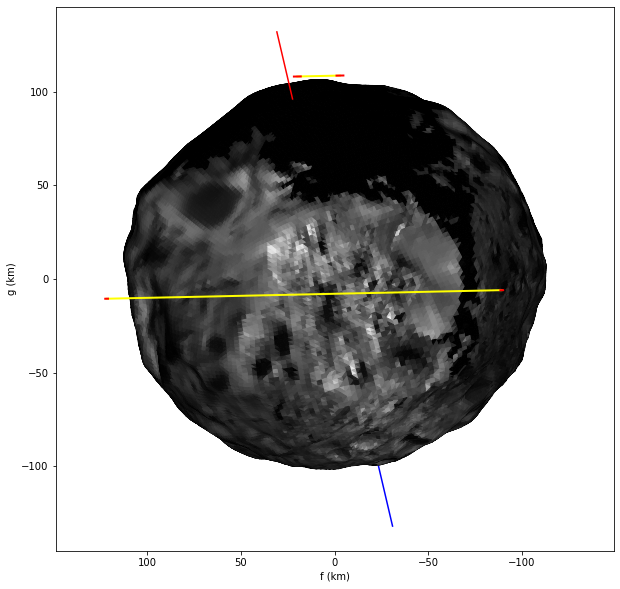

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
phoebe.plot(time=occ.tca)
occ.chords.plot_chords(segment='positive', color='yellow')
occ.chords.plot_chords(segment='error', color='red')
plt.xlim(200,-200)

**Important note**: When plotting the object apparent shape, we only need to provide the time if the `frame` attribute is defined. In the case of Phoebe, it is automaticaly defined using the Archinal et al. (2018) parameters. Please look at the `frame` attribute in the body guideline.

To see the orientation for a given epoch, use the following method:

In [6]:
phoebe.get_orientation(time=occ.tca)

{'sub_observer': '332.494 22.3667',
 'sub_solar': '332.493 22.3668',
 'pole_position_angle': <Quantity 13.17471577 deg>,
 'pole_aperture_angle': <Quantity 22.36671143 deg>}

The plot shows the occultation chords does not fit well with the projected shape and position, which means an error in ephemeris offset and/or in orientation.

The first approach can be assuming an error in ephemeris offset only. In this case, we do not need to change the orientation. Let's fit the shape providing a range of offsets:

In [7]:
res1 = occ.fit_shape(center_f=30, dcenter_f=30, center_g=30, dcenter_g=30, loop=50000)

100%|████████████████████████████████████| 50000/50000 [01:04<00:00, 775.37it/s]


Which results are:

In [8]:
print(res1)

Minimum chi-square: 41.268
Number of fitted points: 4
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 20.634

center_f:
    1-sigma: 16.267 +/- 0.461
    3-sigma: 16.295 +/- 1.530

center_g:
    1-sigma: 8.409 +/- 0.623
    3-sigma: 8.522 +/- 2.647

scale:
    1-sigma: 1.000 +/- 0.000
    3-sigma: 1.000 +/- 0.000



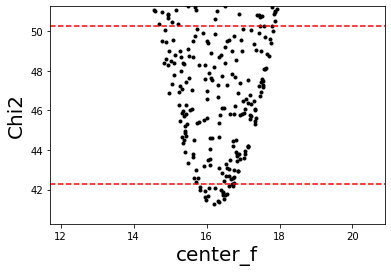

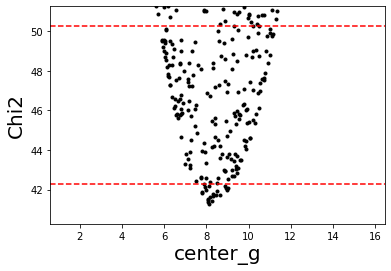

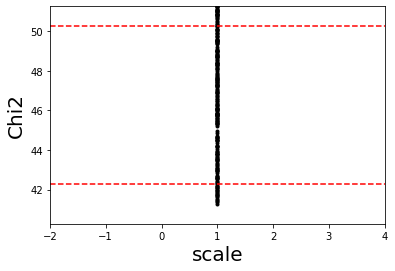

In [9]:
res1.plot_chi2()

Now, let's redo the plot and see if the occultation can now fit the shape.

(200.0, -200.0)

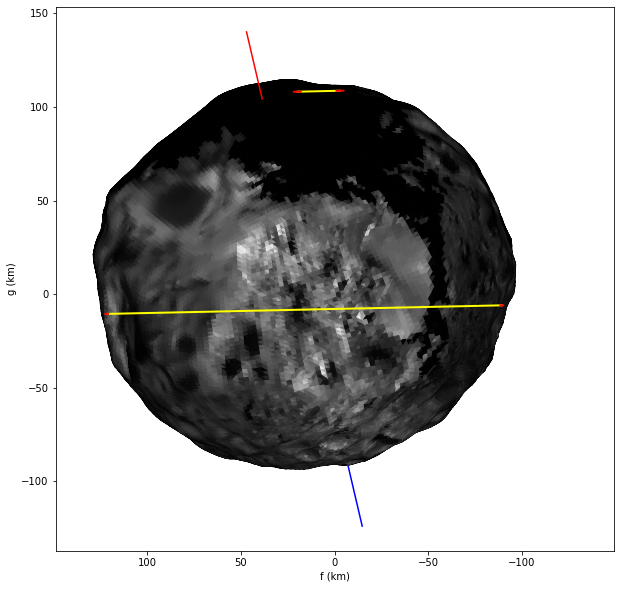

In [10]:
plt.figure(figsize=(10,10))
phoebe.plot(time=occ.tca, **res1.get_values()) # Note the results are unzipped directly to the plot function of the body
occ.chords.plot_chords(segment='positive', color='yellow')
occ.chords.plot_chords(segment='error', color='red')
plt.xlim(200,-200)

We can note the occultation chords still cannot fit well the shape, so probably it may also have an error in orientation.

**Important note**: SORA can also fit the scale of the 3D shape model. However, Phoebe was observed by Cassini, so its size is very well determined.

**Important note**: SORA does not have a function to fit the orientation by itself due to the large amount of time needed to characterize with precision the limb of the 3d shape object. So we must do it ourselves, looping throught the orientation. The following cells are an example on how to do this kind of fitting. We must use the function `fit_to_limb` available at `sora.occultation.fitting`.

First, let's look at the expected orientation of Phoebe at the occultation epoch, present in cell 6 above. Then, we'll change only the longitudes, since the direction of the pole is well defined.

In [11]:
from sora.occultation.fitting import fit_to_limb
import numpy as np

# necessary command to get the contact points of the occultation
name_chord, fg, error = occ.chords.get_limb_points()

def fit_to_lon(lon):
    sub_observer = f"{lon} 22.4"
    limb = phoebe.shape.get_limb(sub_observer=sub_observer, pole_position_angle=13.2)
    
    # the number of loops is small as we want to first find the global minimum region
    partial_chi2 = fit_to_limb(limb=limb, fg=fg, error=error, center_f=30, dcenter_f=30, center_g=30, dcenter_g=30, loop=6000)
    
    # Includes the longitude value in the chi2 object.
    partial_chi2.data['lon'] = np.repeat(lon, len(partial_chi2))
    partial_chi2._names.append('lon')
    
    return partial_chi2

# looping through all longitudes with a step of two degrees. The sum function will just combine all partial results into one ChiSquare object.
chi2 = np.sum([fit_to_lon(lon) for lon in range(0,360,2)])

100%|██████████████████████████████████████| 6000/6000 [00:08<00:00, 669.35it/s]


In [12]:
print(chi2)

Minimum chi-square: 0.184
Number of fitted points: 4
Number of fitted parameters: 3
Minimum chi-square per degree of freedom: 0.184

center_f:
    1-sigma: 17.716 +/- 0.436
    3-sigma: 17.483 +/- 2.038

center_g:
    1-sigma: 8.265 +/- 0.753
    3-sigma: 8.959 +/- 3.443

scale:
    1-sigma: 1.000 +/- 0.000
    3-sigma: 1.000 +/- 0.000

lon:
    1-sigma: 127.000 +/- 3.000
    3-sigma: 125.000 +/- 9.000



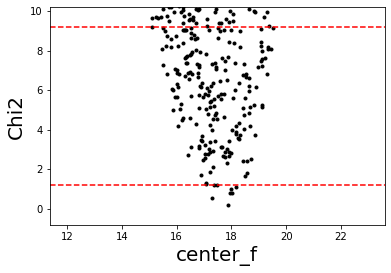

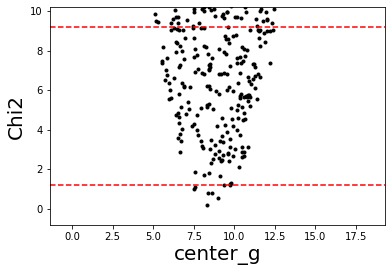

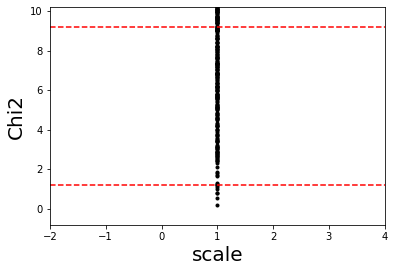

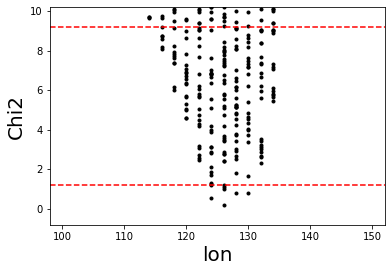

In [13]:
chi2.plot_chi2()

Now we can plot the occultation again with the new orientation

/home/altair/Documentos/códigos/SORA/sora/body/core.py:444: UserWarning: No time is giving or frame is not defined. Plotting without computing orientation. To provide orientation, please plot from shape directly.
  warnings.warn('No time is giving or frame is not defined. Plotting without computing orientation. '


(200.0, -200.0)

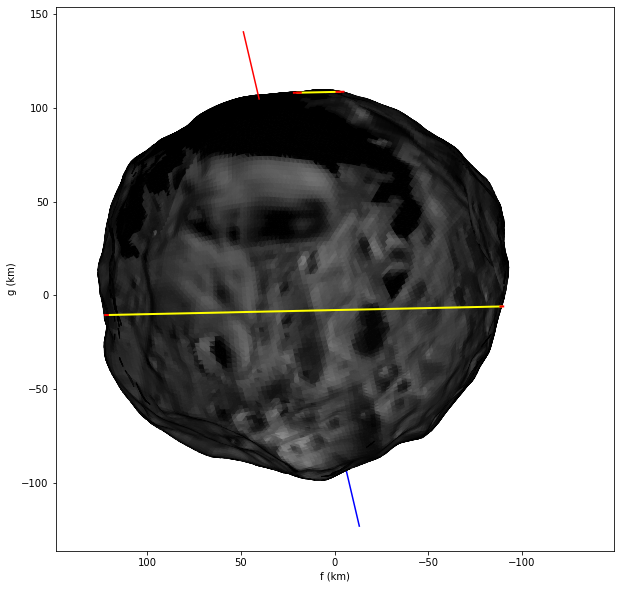

In [14]:
plt.figure(figsize=(10,10))
phoebe.plot(sub_observer="123.0 22.4", pole_position_angle=13.2, center_f=17.8, center_g=8.7)
occ.chords.plot_chords(segment='positive', color='yellow')
occ.chords.plot_chords(segment='error', color='red')
plt.xlim(200,-200)

The occultation chords fit much better the 3D shape now. To have better values, we should redo the fitting process using smaller steps in longitude.

And the final astrometric position is:

In [15]:
occ.new_astrometric_position(time=occ.tca, offset=[17.8, 8.7, 'km'], error=[0.5, 1.0, 'km'])

Ephemeris offset (km): X = 17.8 km +/- 0.5 km; Y = 8.7 km +/- 1.0 km
Ephemeris offset (mas): da_cos_dec = 2.700 +/- 0.076; d_dec = 1.319 +/- 0.152

Astrometric object position at time 2017-07-06 16:07:09.000 for reference 'geocenter'
RA = 17 31 03.0403552 +/- 0.203 mas; DEC = -22 00 57.352765 +/- 0.238 mas


We should notice in Gomes-Júnior et al. (2020) the analysis was pre-SORA, and the catalogue used was Gaia-DR2, so there may be differences in the result found in this example and the published one.